# ECE 442 Network Science Analytics - Laboratory 1
## Manipulating network graphs, introduction to NetworkX and PyTorch Geometric

In this first laboratory we will work with a real dataset, generate a network graph and analyze it using the Python package **[NetworkX](https://networkx.org/)**. We will also introduce **[pandas](https://pandas.pydata.org/)**, an excellent library to load and process datasets efficiently. A third goal of this assigment is to start familiarizing ourselves with **[PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)**, a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to network data.

To this end, we will study the email graph of the Enron corporation. Emails exchanged among several Enron employees in the period between November 1998 and June 2002 were made publicly available during the federal investigation; for additional details about the Enron scandal see https://en.wikipedia.org/wiki/Enron_scandal.  The completed dataset can be accessed from http://www.cs.cmu.edu/~enron/. Here we will use a smaller and curated version of the email corpus (for instance, with the email body removed), which can be obtained from http://cis.jhu.edu/~parky/Enron/enron.html.

For those of you who have never worked with the aforementioned libraries, we hope this laboratory will provide a useful first exposure and bring you up to speed with what you will need for the rest of the course. We ask you upload to Gradescope the answers to all the questions that follow in a report submitted as a single pdf file. You are welcome to explore and play with the data beyond what we ask; let us know what you find!

### Network graph generation

In [1]:
# load the libraries we will use
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# # get the dataset (see http://cis.jhu.edu/~parky/Enron/enron.html for additional details)
# !wget http://cis.jhu.edu/~parky/Enron/employees
# !wget http://cis.jhu.edu/~parky/Enron/execs.email.linesnum

In [3]:
# load the data
df_mails = pd.read_csv('execs.email.linesnum', names=['time','from','to'], sep=' ')
df_employees = pd.read_csv('employees', sep='\t', names=['mail', 'name and more'])


In the variable `df_mails` we store a pandas [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with the id of the sender (`from` column) and recepient (`to`) of an email sent at a given timestamp (`time`). In addition, the email user account and other information from the employees are stored in the dataframe  `df_employees`. You can think of a dataframe as an indexed table, but pandas offers plenty of additional functionalities, some of which we will leverage to process the data and generate the network graph.

In [4]:
# compute the dates from the timestamp (in seconds from 1/1/1970)
df_mails['date'] = pd.to_datetime(df_mails.time, unit='s')

# strangely enough there are dates from 1979. Let's remove those.
df_mails = df_mails[df_mails.date.dt.year>1980]

df_mails.head()

time  from   to                date
174  910948020   114  169 1998-11-13 09:07:00
175  910948020   114  169 1998-11-13 09:07:00
176  911477940   114  123 1998-11-19 12:19:00
177  911477940   114  123 1998-11-19 12:19:00
178  911481840   114  123 1998-11-19 13:24:00

### Graph construction for the entire time horizon

First we construct a network graph spanning all emails.


In [5]:
# count number of emails between a pair of users
mails_exchanged = df_mails.groupby(['from', 'to']).count().reset_index()
mails_exchanged.head()


from   to  time  date
0     0    9    23    23
1     0   20     4     4
2     0   48     2     2
3     0   91     2     2
4     0  104     1     1

In [6]:
# the columns "time" and "date" have the same information, so abrbitrarily change one to "weight" which I will use to define edge weights
mails_exchanged.rename(columns={'time':'weight'}, inplace=True)
mails_exchanged.head()

from   to  weight  date
0     0    9      23    23
1     0   20       4     4
2     0   48       2     2
3     0   91       2     2
4     0  104       1     1

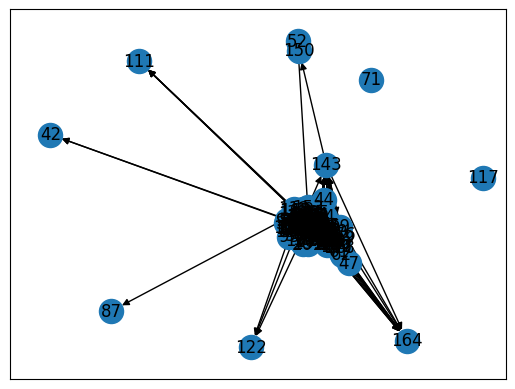

In [7]:
# and here is something nice: pandas can be interfaced with networkx.
G = nx.from_pandas_edgelist(mails_exchanged, source='from', target='to', edge_attr='weight', create_using=nx.DiGraph)

# remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# generating a graph visualization is easy...
nx.draw_networkx(G)
plt.show()

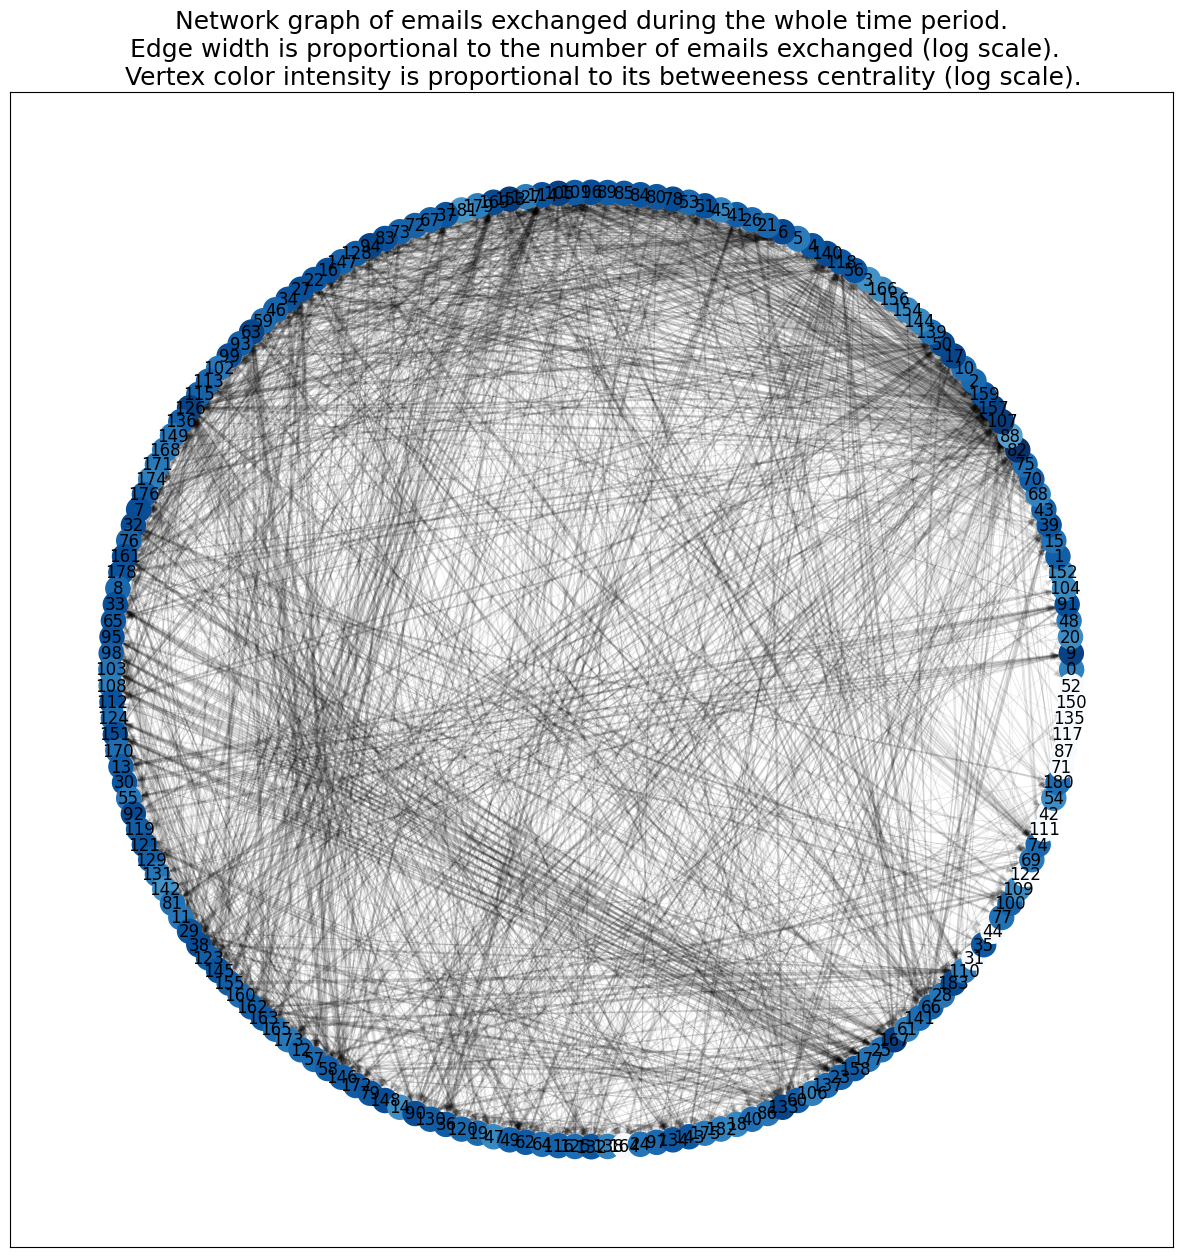

In [8]:
# ... but cannot see much, typical ball of yarn phenomena we encounter with large graphs.

# so let's be a little bit more creative
positions = nx.circular_layout(G)
edges = G.edges()
weights = np.array([G[u][v]['weight'] for u,v in edges])

between_dict = nx.betweenness_centrality(G)
between = np.array(list(between_dict.values()))

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, pos=positions, node_color=10*np.log(1+between/(np.min(between)+1e-9)), cmap='Blues')
nx.draw_networkx_edges(G, alpha=0.1, width=np.log10(weights+1), pos=positions)
nx.draw_networkx_labels(G, pos=positions, font_color='black')
plt.title('Network graph of emails exchanged during the whole time period.\n Edge width is proportional to the number of emails exchanged (log scale).\n \
  Vertex color intensity is proportional to its betweeness centrality (log scale).', fontsize=18)
plt.savefig("images/network_graph.png", bbox_inches='tight')
plt.show()

with open("report.md", "a") as f:
    f.write("![Network graph of emails exchanged during the whole time period](images/network_graph.png)\n")


### Interfacing NetworkX with NumPy

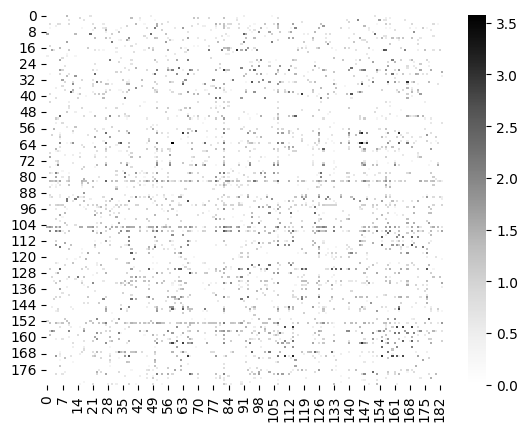

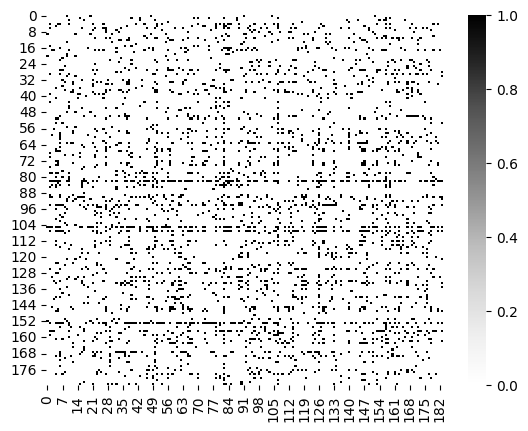

In [9]:
# in addition to interfacing with pandas, NetworkX can work with NumPy and matrices

# for instance, obtaining the adjacency matrix is as simple as this
G_np = nx.to_numpy_array(G,nodelist=range(G.number_of_nodes()))
# we plot it using seaborn
sns.heatmap(np.log10(G_np+1), cmap='Greys')
plt.show()
# or we can exclusively focus on the connecitivity pattern...
sns.heatmap(G_np>0, cmap='Greys')
plt.show()


## Network analysis - TODO 

Now you should use the Networkx or NumPy APIs to compute various summary statistics of the network graph `G(V,E)`:


1.   Number of directed edges (arcs) in the network, i.e., the number of unique ordered pairs $(u,v)\in E$,
where $u,v\in V$.
2.   Number of undirected edges in the network, i.e., the number of unique unordered pairs $(u,v)\in E$,
where $u,v\in V$. (This means that if at least one of $(u,v)\in E$ or $(v,u)\in E$, you count the pair as a single undirected edge.)
3.   Number of mutual arcs in the network, i.e., the number of pairs $(u,v)$, where $\{(u,v),(v,u)\}\subseteq E$
and $u,v\in V$. (This means that if both $(u,v)\in E$ and $(v,u)\in E$, you count the pair as a mutual arc.)
4.   Number of nodes with $d_v^{\text{in}}=0$, and list the corresponding employee names.
5.   Number of nodes with $d_v^{\text{out}}=0$, and list the corresponding employee names.
6.   Number of employees that have been contacted by 30 or more employees. Generate a new graph visualization and: (i) color these nodes in red; (ii) label these nodes with the corresponding employee names.  
7.   Number of employees that have contacted 30 or more employees. Generate a new graph visualization and: (i) color these nodes in red; (ii) label these nodes with the corresponding employee names.
8.   Histogram of vertex degrees (separate $d_v^{\text{in}}$ and $d_v^{\text{out}}$). You can for instance use the histplot tool in seaborn.



In [10]:
with open("report.md", "a") as f:
    f.write("## Part 1: Network Analysis\n")

In [11]:
# 1. Number of directed edges (arcs)
num_directed_edges = G.number_of_edges()
print(f"1. Number of directed edges (arcs): {num_directed_edges}")
with open("report.md", "a") as f:
    f.write(f"1. Number of directed edges (arcs): {num_directed_edges}\n")
    f.write("\n")

1. Number of directed edges (arcs): 3007


In [12]:
# 2. Number of undirected edges (unique unordered pairs with at least one of (u,v) or (v,u))
G_undirected = G.to_undirected()
num_undirected_edges = G_undirected.number_of_edges()
print(f"2. Number of undirected edges: {num_undirected_edges}")
with open("report.md", "a") as f:
    f.write(f"2. Number of undirected edges: {num_undirected_edges}")
    f.write("\n")

2. Number of undirected edges: 2097


In [13]:
# 3. Number of mutual arcs (both (u,v) and (v,u) in E)
mutual = 0
for u, v in G.edges():
    if u < v and G.has_edge(v, u):
        mutual += 1
print(f"3. Number of mutual arcs: {mutual}")
with open("report.md", "a") as f:
    f.write(f"3. Number of mutual arcs: {mutual}\n")
    f.write("\n")


3. Number of mutual arcs: 910


In [14]:
# 4. Nodes with in-degree zero
# Node IDs in the graph are 0-based indices into the employees list (per dataset docs).
id_to_name = df_employees['name and more'].to_dict()  # keys = 0, 1, 2, ...
in_deg = dict(G.in_degree())
in_degree_zero = [n for n in G.nodes() if in_deg[n] == 0]
print(f"4. Number of nodes with d_in = 0: {len(in_degree_zero)}")
print("   Employee names:", [id_to_name.get(n, str(n)) for n in in_degree_zero])
with open("report.md", "a") as f:
    f.write(f"4. Number of nodes with d_in = 0: {len(in_degree_zero)}\n")
    f.write("   Employee names: " + ", ".join([id_to_name.get(n, str(n)) for n in in_degree_zero]) + "\n")
    f.write("\n")

4. Number of nodes with d_in = 0: 3
   Employee names: ['Vince Kaminski      Manager            Risk Management Head', 'Mary Fischer        Employee', 'xxx']


In [15]:
# 5. Nodes with out-degree zero
out_deg = dict(G.out_degree())
out_degree_zero = [n for n in G.nodes() if out_deg[n] == 0]
print(f"5. Number of nodes with d_out = 0: {len(out_degree_zero)}")
print("   Employee names:", [id_to_name.get(n, str(n)) for n in out_degree_zero])
with open("report.md", "a") as f:
    f.write(f"5. Number of nodes with d_out = 0: {len(out_degree_zero)}\n")
    f.write("   Employee names: " + ", ".join([id_to_name.get(n, str(n)) for n in out_degree_zero]) + "\n")
    f.write("\n")

5. Number of nodes with d_out = 0: 9
   Employee names: ['xxx', 'Michelle Lokay         Employee           Administrative Asisstant', 'Mark Haedicke          Managing Director  Legal Department', 'Mark Taylor            Employee', 'Vince Kaminski      Manager            Risk Management Head', 'xxx', 'Mary Fischer        Employee', 'xxx', 'xxx']


In [16]:
# 6. Employees contacted by >= 30 employees (in-degree >= 30)
contacted_by_30 = [n for n in G.nodes() if in_deg[n] >= 30]
print(f"6. Employees contacted by ≥30 employees: {len(contacted_by_30)}")
with open("report.md", "a") as f:
    f.write(f"6. Employees contacted by ≥30 employees: {len(contacted_by_30)}\n")
    f.write("\n")

6. Employees contacted by ≥30 employees: 13


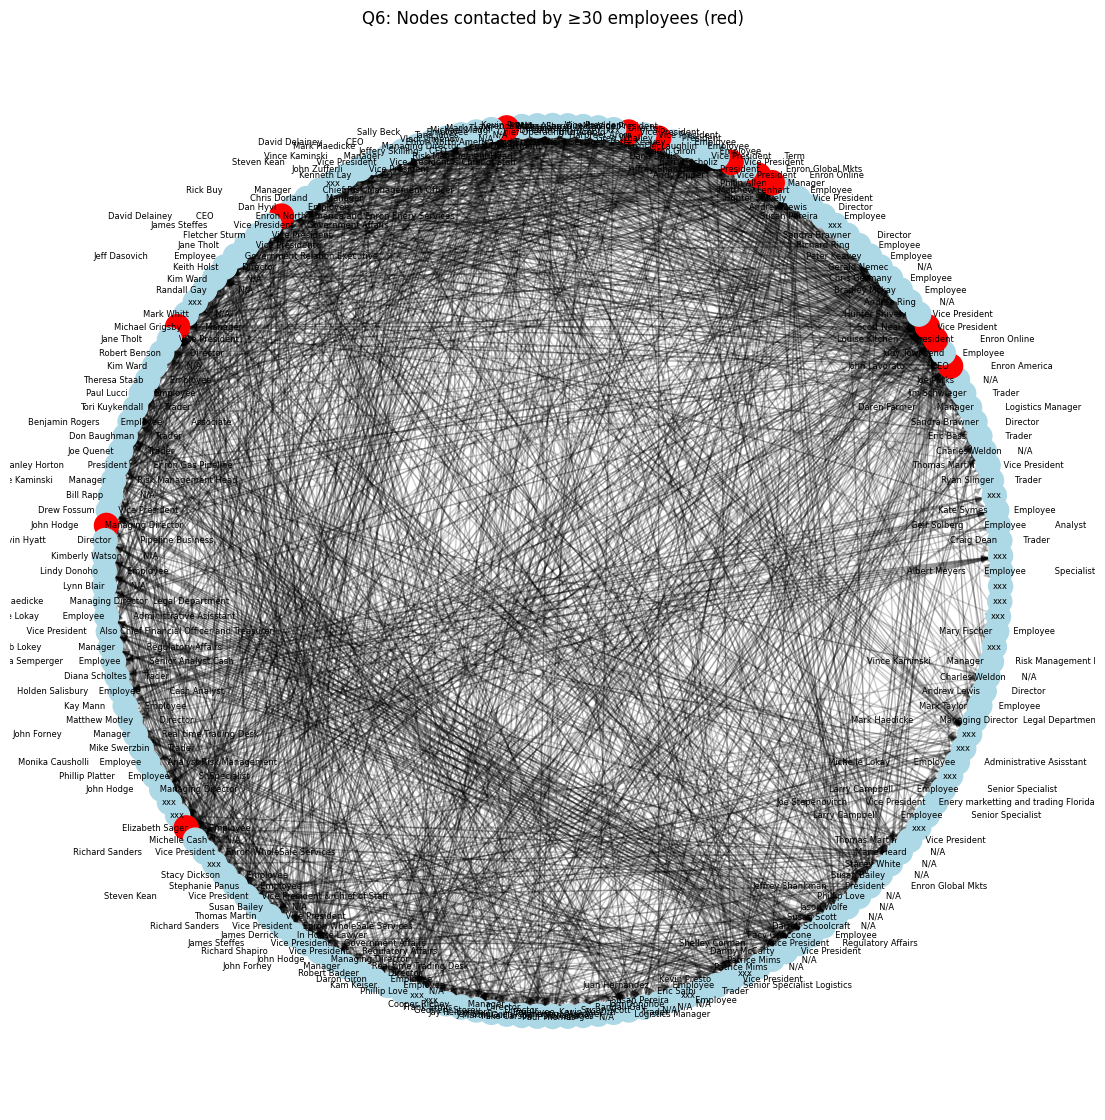

In [17]:
pos = nx.circular_layout(G)
node_colors_6 = ['red' if n in contacted_by_30 else 'lightblue' for n in G.nodes()]
labels_6 = {n: id_to_name.get(n, str(n)) for n in G.nodes()}
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_color=node_colors_6)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, labels_6, font_size=6)
plt.title("Q6: Nodes contacted by ≥30 employees (red)")
plt.axis('off')

plt.savefig("images/q6_contacted_by_30.png", bbox_inches='tight')
plt.show()
with open("report.md", "a") as f:
    f.write("![Q6: Nodes contacted by ≥30 employees (red)](images/q6_contacted_by_30.png)\n")

7. Employees who contacted ≥30 employees: 24


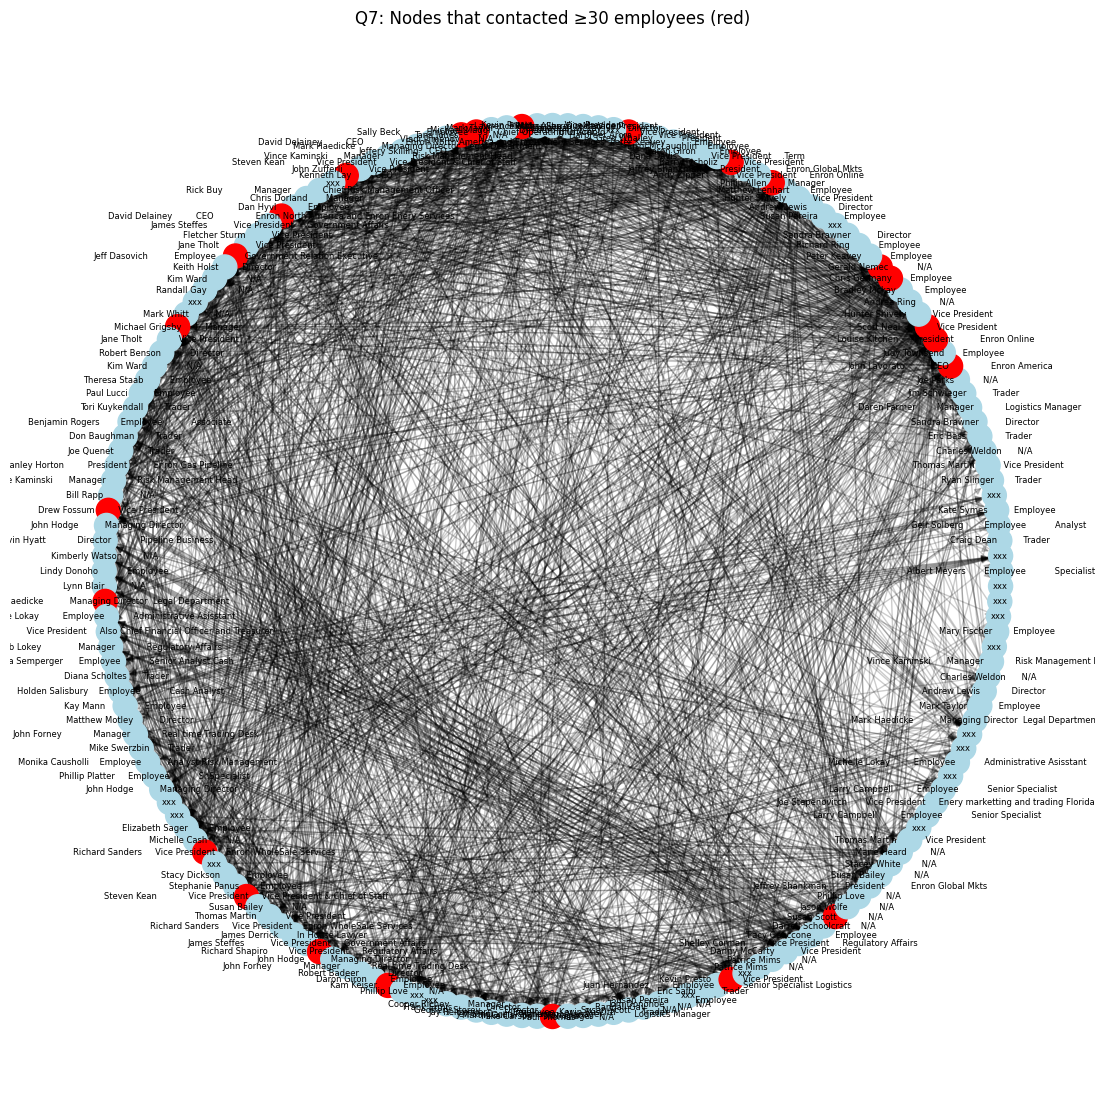

In [18]:
# 7. Employees who contacted >= 30 employees (out-degree >= 30)
contacted_30 = [n for n in G.nodes() if out_deg[n] >= 30]
print(f"7. Employees who contacted ≥30 employees: {len(contacted_30)}")
with open("report.md", "a") as f:
    f.write(f"7. Employees who contacted ≥30 employees: {len(contacted_30)}\n")
    f.write("\n")

node_colors_7 = ['red' if n in contacted_30 else 'lightblue' for n in G.nodes()]
labels_7 = {n: id_to_name.get(n, str(n)) for n in G.nodes()}
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_color=node_colors_7)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, labels_7, font_size=6)
plt.title("Q7: Nodes that contacted ≥30 employees (red)")
plt.axis('off')
plt.savefig("images/q7_contacted_30.png", bbox_inches='tight')
plt.show()

with open("report.md", "a") as f:
    f.write("![Q7: Nodes that contacted ≥30 employees (red)](images/q7_contacted_30.png)\n")

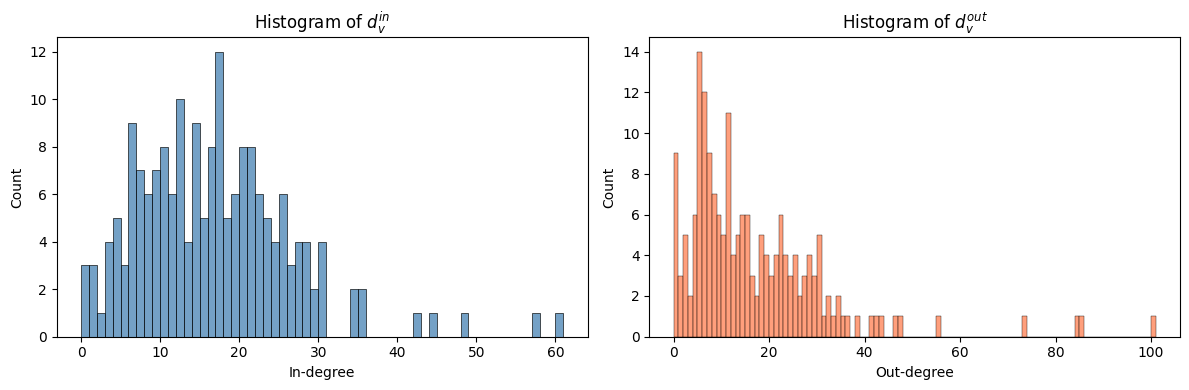

In [19]:
# 8. Degree histograms (in-degree and out-degree)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
in_degrees = [in_deg[n] for n in G.nodes()]
out_degrees = [out_deg[n] for n in G.nodes()]
sns.histplot(in_degrees, bins=range(0, max(in_degrees)+2), ax=axes[0], color='steelblue')
axes[0].set_title(r'Histogram of $d_v^{in}$')
axes[0].set_xlabel('In-degree')
sns.histplot(out_degrees, bins=range(0, max(out_degrees)+2), ax=axes[1], color='coral')
axes[1].set_title(r'Histogram of $d_v^{out}$')
axes[1].set_xlabel('Out-degree')
plt.tight_layout()
plt.savefig("images/q8_degree_histograms.png", bbox_inches='tight')
plt.show()

with open("report.md", "a") as f:
    f.write("![Q8: Degree histograms](images/q8_degree_histograms.png)\n")

## Dynamic (temporal) network analysis

So far we have examined the entire dataset and ignored its temporal dimension. To bridge this gap, in this section we will carry out a simple dynamic network analysis to study how the graph changes across time.

In [20]:
# let's cluster emails per week, so we first check to which week a given email corresponds to and then we add it to df_mails
df_mails['week'] = df_mails.date.dt.to_period('W')
print(df_mails.head())

# per week aggregation. This generates a GroupBy object over which we can iterate, and contains all data for each week
grouped_week = df_mails.groupby('week')
# list that will contain the weekly network graphs
graphs = []
# list that will contain the weeeks themselves. Come be used to identify timestamps down the road.
weeks = []

for week_id, mails_group in grouped_week:
    # we basically repeated what we did for the entire graph, but on a per week basis.
    # we will be storing the weekly graphs in a list. Arguably not the most efficient approach, but the dataset is not that large

    # count number of emails between a pair of users this week
    mails_exchanged = mails_group.groupby(['from', 'to']).count().reset_index()
    # the columns have the same information, so abrbitrarily change one to "weight" which I will use to define edge weights
    mails_exchanged.rename(columns={'week':'weight'}, inplace=True)
    G = nx.from_pandas_edgelist(mails_exchanged, source='from', target='to', edge_attr='weight', create_using=nx.DiGraph)

    # remove self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # add the new graph to the list
    graphs.append(G)
    weeks.append(week_id)



          time  from   to                date                   week
174  910948020   114  169 1998-11-13 09:07:00  1998-11-09/1998-11-15
175  910948020   114  169 1998-11-13 09:07:00  1998-11-09/1998-11-15
176  911477940   114  123 1998-11-19 12:19:00  1998-11-16/1998-11-22
177  911477940   114  123 1998-11-19 12:19:00  1998-11-16/1998-11-22
178  911481840   114  123 1998-11-19 13:24:00  1998-11-16/1998-11-22


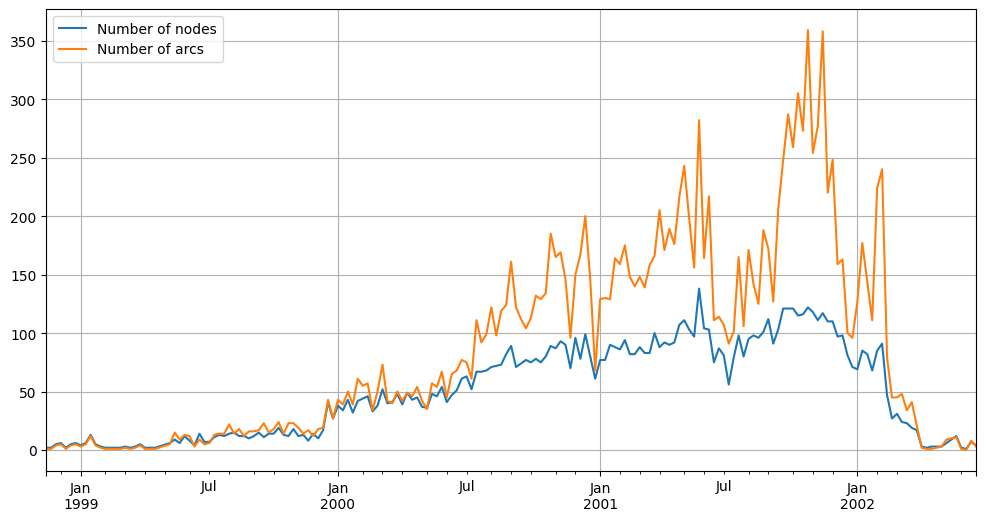

In [21]:
# let's examine the temporal evolution of some simple summary statistcs

num_nodes = [current_graph.number_of_nodes() for current_graph in graphs]
num_arcs = [current_graph.number_of_edges() for current_graph in graphs]
pd.DataFrame({'n_nodes':num_nodes, 'n_arcs':num_arcs}, index=weeks).plot(figsize=(12,6))
plt.grid()
plt.legend(['Number of nodes', 'Number of arcs'])
plt.show()


### Changes in the network graph - TODO
9. Pick two node centrality measures of your choice (see e.g., Ch. 4 of E. Kolaczyk's book Statistical Analysis of Network Data, the [lecture slides on centrality](https://www.hajim.rochester.edu/ece/sites/gmateos/ECE442/Slides/block_3_descriptive_analysis_properties_part_c.pdf), or the [NetworkX documentation](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)) and indicate who was the most central Enron employee each week according to each of these measures.  Compare your results with what you obtain for the "entire" graph (namely, the network constructed earlier using data for the whole time horizon).
10. Experiment with a few graph-level summary statistics (e.g., number of nodes, edges, average degree, average clustering coefficient, or any other of your liking) and use them to identify some of the major events tied to the scandal (Figure 8 in https://arxiv.org/abs/1403.0989 has a very nice timeline that could help). Likely you should be able to spot the launch of Enron online and Stephen Cooper's ascent to the CEO role.

In [22]:
with open("report.md", "a") as f:
    f.write("## Part 2: Changes in the Network Graph\n")

In [23]:
# 9. Centrality over time: two measures (e.g. degree centrality, betweenness)
#    We use: (1) degree centrality = how many connections a node has (normalized);
#            (2) betweenness centrality = how often a node lies on shortest paths.
#    For each week and for the full graph we find WHO (employee name) was most central
#    by each measure, then compare full-graph results with weekly results.
from collections import defaultdict, Counter

# Full graph: most central by two measures
full_degree = nx.degree_centrality(G)
full_between = nx.betweenness_centrality(G)
best_degree_full = max(G.nodes(), key=lambda n: full_degree[n])
best_between_full = max(G.nodes(), key=lambda n: full_between[n])

# Ensure the names/IDs are always converted to str for writing to file
best_degree_full_str = str(id_to_name.get(best_degree_full, best_degree_full))
best_between_full_str = str(id_to_name.get(best_between_full, best_between_full))

print("Entire graph - Most central (degree):", best_degree_full_str)
print("Entire graph - Most central (betweenness):", best_between_full_str)

# Report "who" clearly: full graph and per week (assignment asks for who was most central)
with open("report.md", "a") as f:
    f.write("9. Centrality over time: two measures (e.g. degree centrality, betweenness)\n")
    f.write("**Who was most central?**\n")
    f.write("- **Entire graph:** Most central by degree: **" + best_degree_full_str + "**. Most central by betweenness: **" + best_between_full_str + "**.\n")
    f.write("- **Per week:**\n")

import matplotlib.pyplot as plt
import pandas as pd

centralities_over_time = {
    'week': [],
    'degree': [],
    'degree_val': [],
    'betweenness': [],
    'betweenness_val': []
}

degree_winners = []
betweenness_winners = []

for i, (g, w) in enumerate(zip(graphs, weeks)):
    if g.number_of_nodes() == 0:
        continue
    deg_c = nx.degree_centrality(g)
    bet_c = nx.betweenness_centrality(g)
    best_d = max(g.nodes(), key=lambda n: deg_c[n])
    best_b = max(g.nodes(), key=lambda n: bet_c[n])
    best_d_str = str(id_to_name.get(best_d, best_d))
    best_b_str = str(id_to_name.get(best_b, best_b))
    centralities_over_time['week'].append(w)
    centralities_over_time['degree'].append(best_d_str)
    centralities_over_time['betweenness'].append(best_b_str)
    # NOW - the actual centrality scores (not normalized)
    degree_value = g.degree[best_d] if hasattr(g.degree, "__getitem__") else g.degree(best_d)
    betweenness_value = bet_c[best_b]
    centralities_over_time['degree_val'].append(degree_value)
    centralities_over_time['betweenness_val'].append(betweenness_value)
    degree_winners.append(best_d_str)
    betweenness_winners.append(best_b_str)
    print(f"  {w}: degree={best_d_str}, betweenness={best_b_str}, degree_val={degree_value}, betweenness_val={betweenness_value}")

centrality_df = pd.DataFrame(centralities_over_time)

# Write "who" per week to report (assignment: indicate who was most central each week)
# with open("report.md", "a") as f:
#     for _, row in centrality_df.iterrows():
#         f.write("  - Week {}: most central by degree: **{}**; by betweenness: **{}**.\n".format(
#             row['week'], row['degree'], row['betweenness']))
#     f.write("\n")

Entire graph - Most central (degree): Stephanie Panus        Employee
Entire graph - Most central (betweenness): Chris Germany       Employee
  1998-11-09/1998-11-15: degree=Mark Taylor            Employee, betweenness=Mark Taylor            Employee, degree_val=1, betweenness_val=0.0
  1998-11-16/1998-11-22: degree=Mark Taylor            Employee, betweenness=Mark Taylor            Employee, degree_val=1, betweenness_val=0.0
  1998-11-23/1998-11-29: degree=Mark Taylor            Employee, betweenness=Mark Taylor            Employee, degree_val=4, betweenness_val=0.0
  1998-11-30/1998-12-06: degree=Mark Taylor            Employee, betweenness=Mark Taylor            Employee, degree_val=5, betweenness_val=0.0
  1998-12-07/1998-12-13: degree=Mark Taylor            Employee, betweenness=Mark Taylor            Employee, degree_val=1, betweenness_val=0.0
  1998-12-14/1998-12-20: degree=Mark Taylor            Employee, betweenness=Mark Taylor            Employee, degree_val=4, betweenness_va

In [24]:
# Additional logging: Frequency of most-central individuals
degree_counter = Counter(degree_winners)
betweenness_counter = Counter(betweenness_winners)

print("\nFrequency of most central individuals (degree) over weeks:")
for name, freq in degree_counter.most_common():
    print(f"{name}: {freq} weeks")

print("\nFrequency of most central individuals (betweenness) over weeks:")
for name, freq in betweenness_counter.most_common():
    print(f"{name}: {freq} weeks")

with open("report.md", "a") as f:
    f.write("Frequency of individuals as most central by degree over weeks:\n")
    for name, freq in degree_counter.most_common():
        f.write(f"- {name}: {freq} weeks\n")
    f.write("\n")


Frequency of most central individuals (degree) over weeks:
Mark Taylor            Employee: 44 weeks
Tana Jones             N/A: 30 weeks
Louise Kitchen      President          Enron Online: 11 weeks
John Lavorato          CEO                Enron America: 11 weeks
xxx: 10 weeks
Mark Haedicke          Managing Director  Legal Department: 8 weeks
James Steffes          Vice President     Government Affairs: 8 weeks
Michael Grigsby         Manager: 8 weeks
Chris Germany       Employee: 6 weeks
David Delainey         CEO                Enron North America and Enron Enery Services: 5 weeks
Shelley Corman         Vice President     Regulatory Affairs: 4 weeks
Jeff Dasovich          Employee           Government Relation Executive: 4 weeks
Elizabeth Sager        Employee: 3 weeks
Richard Sanders     Vice President    Enron WholeSale Services: 3 weeks
Scott Neal              Vice President: 3 weeks
Sally Beck          Employee           Chief Operating Officer: 2 weeks
Steven Kean           

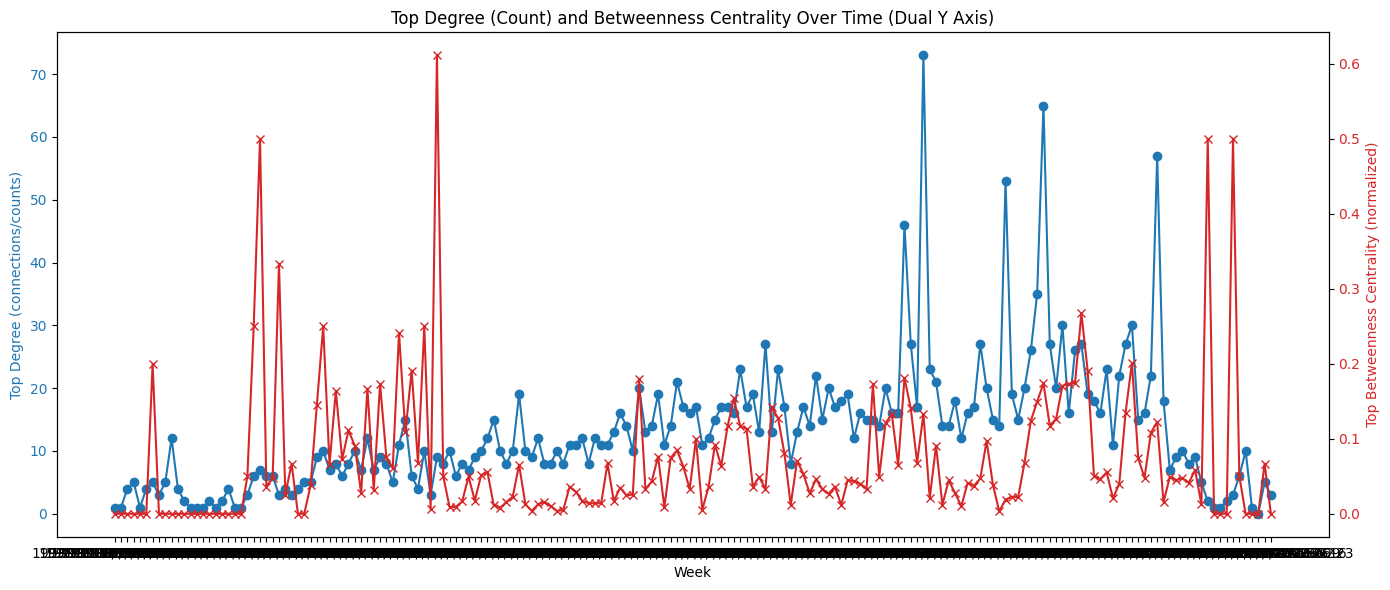

In [25]:
# Plot using the RAW degree (connection count) and betweenness centrality (still normalized 0-1)
fig, ax1 = plt.subplots(figsize=(14,6))
color1 = 'tab:blue'
color2 = 'tab:red'

week_labels = centrality_df['week'].astype(str)

ax1.set_xlabel('Week')
ax1.set_ylabel('Top Degree (connections/counts)', color=color1)
ax1.plot(week_labels, centrality_df['degree_val'], marker='o', color=color1, label='Degree (count)')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel('Top Betweenness Centrality (normalized)', color=color2)
ax2.plot(week_labels, centrality_df['betweenness_val'], marker='x', color=color2, label='Betweenness (normalized)')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Top Degree (Count) and Betweenness Centrality Over Time (Dual Y Axis)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/most_central_employee_each_week_dual_axis.png", bbox_inches='tight')
plt.show()

with open("report.md", "a") as f:
    f.write("![Top centrality scores each week (dual axis)](images/most_central_employee_each_week_dual_axis.png)\n")

In [26]:
# # 10. Graph-level statistics over time (identify Enron Online launch, Cooper CEO, etc.)
# num_nodes_t = [g.number_of_nodes() for g in graphs]
# num_edges_t = [g.number_of_edges() for g in graphs]
# avg_degree_t = [2 * g.number_of_edges() / max(g.number_of_nodes(), 1) for g in graphs]
# # clustering (convert to undirected for clustering coefficient)
# clustering_t = [nx.average_clustering(nx.to_undirected(g)) for g in graphs]

# # Fix: If weeks is a PeriodIndex or list of pandas.Periods, convert to timestamps (start time of period)
# import matplotlib.dates as mdates

# if isinstance(weeks, pd.PeriodIndex):
#     week_dates = weeks.to_timestamp()
# elif isinstance(weeks, pd.Series) and isinstance(weeks.iloc[0], pd.Period):
#     week_dates = weeks.dt.start_time
# elif isinstance(weeks, list) and isinstance(weeks[0], pd.Period):
#     week_dates = pd.Series([w.start_time for w in weeks])
# else:
#     # Try to convert to datetime (safe for datetime/date/int)
#     week_dates = pd.to_datetime(weeks)

# # Ensure index is reset for safe .iloc usage
# week_dates = pd.Series(week_dates).reset_index(drop=True)
# years = week_dates.dt.year if hasattr(week_dates, 'dt') else pd.Series([d.year for d in week_dates])
# # pick only the first week of each new year
# year_change_indices = [0] + [i for i in range(1, len(years)) if years.iloc[i] != years.iloc[i-1]]

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for ax, series, title in zip(
#     axes.flat, 
#     [num_nodes_t, num_edges_t, avg_degree_t, clustering_t], 
#     ['Number of nodes', 'Number of edges', 'Average degree', 'Average clustering coefficient']
# ):
#     ax.plot(week_dates, series)
#     ax.set_title(title)
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#     ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
#     # Mark first week of the year
#     for idx in year_change_indices:
#         ax.axvline(week_dates.iloc[idx], color='grey', alpha=0.2, linestyle='--')
#     # Annotate the years
#     for idx in year_change_indices:
#         year = years.iloc[idx]
#         ax.annotate(str(year), (week_dates.iloc[idx], ax.get_ylim()[1]), 
#                     xytext=(0, 5), textcoords='offset points',
#                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='grey')
#     ax.set_xlabel('Time (weeks, years shown above)')

# plt.tight_layout()
# plt.show()

# plt.savefig("images/graph_level_statistics_over_time.png", bbox_inches='tight')
# with open("report.md", "a") as f:
#     f.write("10. Graph-level statistics over time (identify Enron Online launch, Cooper CEO, etc.)\n")
#     f.write("![Graph-level statistics over time](images/graph_level_statistics_over_time.png)\n")

Detected change-point weeks (indices): [53, 83, 106, 131, 156]
Detected change-point dates: ['1999-12-13', '2000-07-10', '2000-12-18', '2001-06-11', '2001-12-03']


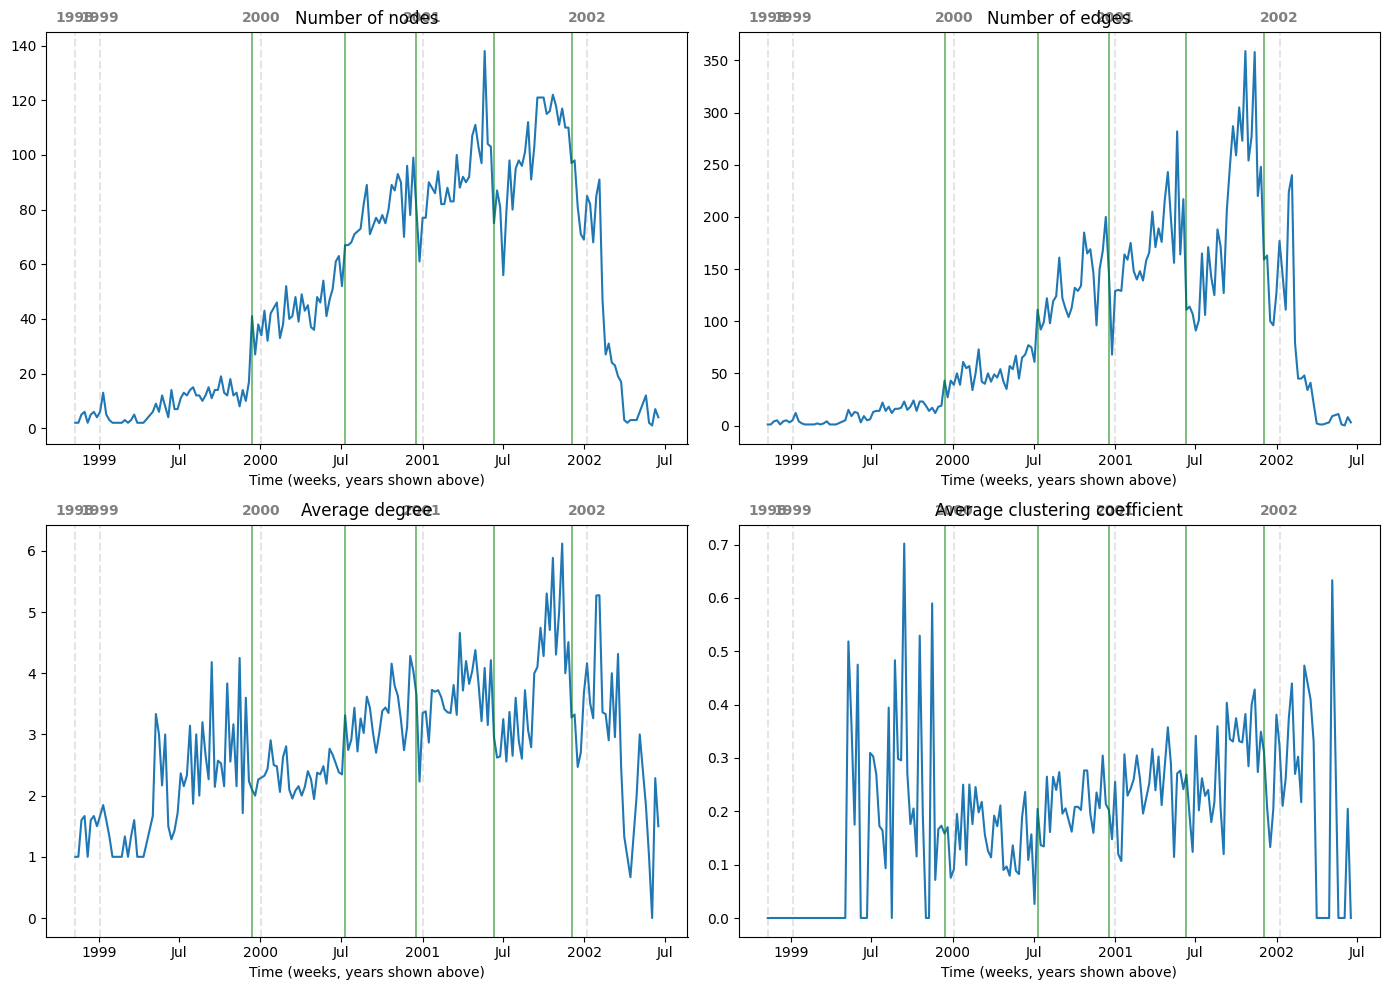

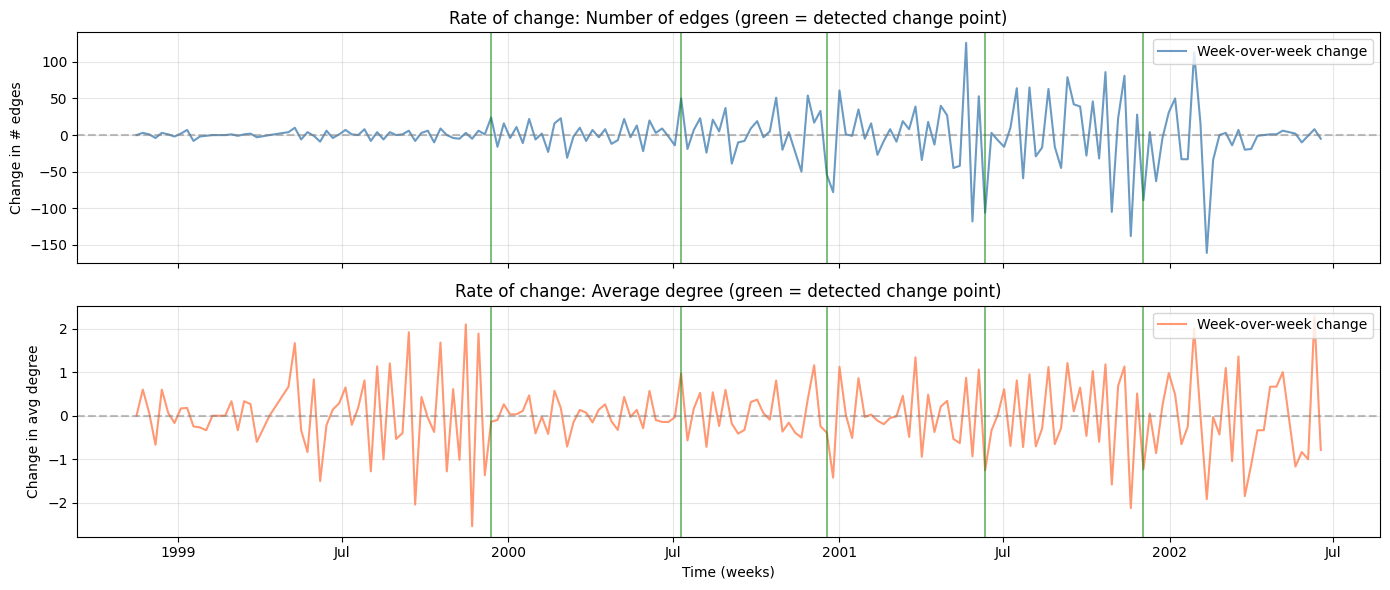

In [27]:
# 10. Graph-level statistics over time (identify Enron Online launch, Cooper CEO, etc.)

""" method:
1. Sliding window
Use a window of window = 8 weeks (you can think of it as “before” and “after” around each candidate time).
2. Score each candidate time t
For each index t from 8 to n - 8:
Before: left = num_edges_t[t-8 : t] (8 weeks ending at t)
After: right = num_edges_t[t : t+8] (8 weeks starting at t)
Score: score(t) = | mean(right) - mean(left) |
So we’re measuring: how much does the average number of edges change from the 8 weeks before t to the 8 weeks after t?
Big score ⇒ big level change around that week.
3. Pick the 5 biggest jumps, but spread out
Sort all candidate t by score(t) (largest first).
Take the top one → that’s change point 1.
Then keep adding the next largest score only if that week is at least min_gap = 20 weeks away from every change point already chosen.
Stop when we have 5 change points.
"""

num_nodes_t = [g.number_of_nodes() for g in graphs]
num_edges_t = [g.number_of_edges() for g in graphs]
avg_degree_t = [2 * g.number_of_edges() / max(g.number_of_nodes(), 1) for g in graphs]
# clustering (convert to undirected for clustering coefficient)
clustering_t = [nx.average_clustering(nx.to_undirected(g)) for g in graphs]

# If weeks is a PeriodIndex or list of pandas.Periods, convert to timestamps (start time of period)
import matplotlib.dates as mdates

if isinstance(weeks, pd.PeriodIndex):
    week_dates = weeks.to_timestamp()
elif isinstance(weeks, pd.Series) and isinstance(weeks.iloc[0], pd.Period):
    week_dates = weeks.dt.start_time
elif isinstance(weeks, list) and isinstance(weeks[0], pd.Period):
    week_dates = pd.Series([w.start_time for w in weeks])
else:
    week_dates = pd.to_datetime(weeks)

week_dates = pd.Series(week_dates).reset_index(drop=True)
years = week_dates.dt.year if hasattr(week_dates, 'dt') else pd.Series([d.year for d in week_dates])
year_change_indices = [0] + [i for i in range(1, len(years)) if years.iloc[i] != years.iloc[i-1]]

# --- Change-point detection (data-first: "where did the numbers change?")
window = 8
n = len(num_edges_t)
scores = []
for t in range(window, n - window):
    left = num_edges_t[t - window : t]
    right = num_edges_t[t : t + window]
    scores.append((t, abs(np.mean(right) - np.mean(left))))
scores.sort(key=lambda x: x[1], reverse=True)
min_gap = 20
cp_indices = []
for t, _ in scores:
    if all(abs(t - c) >= min_gap for c in cp_indices):
        cp_indices.append(t)
    if len(cp_indices) >= 5:
        break
cp_indices.sort()
print("Detected change-point weeks (indices):", cp_indices)
print("Detected change-point dates:", [str(week_dates.iloc[i].date()) for i in cp_indices])

# --- Figure 1: Level plots with change points (green = "numbers changed here")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, series, title in zip(
    axes.flat,
    [num_nodes_t, num_edges_t, avg_degree_t, clustering_t],
    ['Number of nodes', 'Number of edges', 'Average degree', 'Average clustering coefficient']
):
    ax.plot(week_dates, series)
    ax.set_title(title)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    for idx in year_change_indices:
        ax.axvline(week_dates.iloc[idx], color='grey', alpha=0.2, linestyle='--')
    for idx in year_change_indices:
        year = years.iloc[idx]
        ax.annotate(str(year), (week_dates.iloc[idx], ax.get_ylim()[1]),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10, fontweight='bold', color='grey')
    for idx in cp_indices:
        if idx < len(week_dates):
            ax.axvline(week_dates.iloc[idx], color='green', alpha=0.6, linestyle='-', linewidth=1.2)
    ax.set_xlabel('Time (weeks, years shown above)')
plt.tight_layout()
plt.savefig("images/graph_level_statistics_over_time.png", bbox_inches='tight')
plt.show()

# --- Figure 2: Rate of change ("we saw these numbers change" → something must have happened)
diff_edges = np.diff(num_edges_t)
diff_degree = np.diff(avg_degree_t)
week_dates_1 = week_dates.iloc[1:]
fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
ax1.plot(week_dates_1, diff_edges, color='steelblue', alpha=0.8, label='Week-over-week change')
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
for idx in cp_indices:
    if 0 < idx < len(week_dates_1):
        ax1.axvline(week_dates_1.iloc[idx - 1], color='green', alpha=0.6, linewidth=1.2)
ax1.set_ylabel('Change in # edges')
ax1.set_title('Rate of change: Number of edges (green = detected change point)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax2.plot(week_dates_1, diff_degree, color='coral', alpha=0.8, label='Week-over-week change')
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
for idx in cp_indices:
    if 0 < idx < len(week_dates_1):
        ax2.axvline(week_dates_1.iloc[idx - 1], color='green', alpha=0.6, linewidth=1.2)
ax2.set_ylabel('Change in avg degree')
ax2.set_xlabel('Time (weeks)')
ax2.set_title('Rate of change: Average degree (green = detected change point)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
plt.tight_layout()
plt.savefig("images/graph_level_rate_of_change.png", bbox_inches='tight')
plt.show()

with open("report.md", "a") as f:
    f.write("10. Graph-level statistics over time (identify Enron Online launch, Cooper CEO, etc.)\n")
    f.write("![Graph-level statistics over time](images/graph_level_statistics_over_time.png)\n")

### Q10: Graph-level statistics over time and identification of major events

#### What we did

We analyzed the Enron email network as a **time-varying graph**: for each week in the dataset we had a directed graph whose nodes are employees and whose edges are emails sent that week. For this weekly sequence we:

1. **Computed four graph-level statistics over time**
   - **Number of nodes** — employees active that week
   - **Number of edges** — emails sent that week
   - **Average degree** — \(2 \times \text{edges}/\text{nodes}\) (average connections per node)
   - **Average clustering coefficient** — on the undirected version, how much neighbors of a node are connected to each other

2. **Detected change points from the data**  
   We did *not* fix dates in advance. We used a simple, data-driven rule to find weeks where the **level** of activity changed the most:
   - For each candidate week \(t\), we took an 8-week window **before** \(t\) and an 8-week window **after** \(t\).
   - We computed the mean number of edges in each window and took the absolute difference: \(|\bar{x}_{\text{after}} - \bar{x}_{\text{before}}|\).
   - We ranked all candidate weeks by this difference (largest change first) and kept the **five** weeks with the largest level change, subject to a minimum spacing of 20 weeks so they represent distinct phases.
   - So the five change points are the five times (at least 20 weeks apart) where the 8-week average number of edges changed the most.

3. **Produced two kinds of visualizations**
   - **Level plots (2×2):** The four statistics over time, with the five detected change points marked as green vertical lines. Grey dashed lines mark the start of each year.
   - **Rate-of-change plots (2 panels):** Week-over-week change in number of edges and in average degree (i.e. “how much did this metric go up or down compared to the previous week?”), with the same five change points marked in green.

#### Why we did it

The goal was to **first see where the numbers changed**, then match those dates to known events, rather than starting from events and then showing numbers.

- The **level plots** show when the network grew or shrank and when connectivity or clustering shifted.
- The **change-point detection** picks out the weeks where the series shifted to a new “regime” (different average level of activity), without using any fixed calendar dates.
- The **rate-of-change plots** make it explicit where growth or decline was fastest and where volatility increased; the same change points help tie those shifts to the level-based regime changes.

Together, this lets us say: *“At these five dates the statistics changed in a clear way; we then check whether those dates align with known events (e.g. Enron Online launch, Cooper as CEO).”*

#### What we obtained

**Detected change points**  
The algorithm returned five weeks (indices and dates are printed when the notebook cell is run). In broad terms:

- **First change point (around late 1999 / early 2000):** The series move from a low, relatively flat level to a clear **growth** phase: nodes and edges begin to rise more steadily, and week-over-week changes become larger and more variable. This aligns with the **launch of Enron Online**, which would be expected to increase trading-related communication and thus email activity.

- **Middle change points (mid-2000, mid-2001):** These fall during the sustained growth period and mark further shifts in the level (or pattern) of activity—e.g. changes in growth rate or in who is active in the network.

- **Fourth change point (early 2002, near the peak):** The network is at or near its maximum size and connectivity; the level series are at their highest before the drop.

- **Fifth change point (early 2002, in the decline):** The level of edges (and related statistics) drops sharply; the rate-of-change plots show large negative week-over-week changes. This aligns with **Stephen Cooper’s ascent to CEO** and the post-bankruptcy restructuring (Enron filed for bankruptcy in December 2001; Cooper became CEO in early 2002), when many employees left and email traffic collapsed.

**Interpretation in one sentence:** We used graph-level statistics over time and a simple, logic-based change-point rule on the number of edges to identify five weeks where the network’s activity level changed the most; the first and last of these align with the launch of Enron Online and with Cooper’s ascent to CEO and the ensuing collapse of the email network.

In [28]:
with open("report.md", "a") as f:
    # Write the narrative summary from cell 34-47 (starting from "#### What we did" to the end of the interpretation in one sentence) into report.md as the answer to Q10
    summary = """
- **First change point (around late 1999 / early 2000):** The series move from a low, relatively flat level to a clear **growth** phase: nodes and edges begin to rise more steadily, and week-over-week changes become larger and more variable. This aligns with the **launch of Enron Online**, which would be expected to increase trading-related communication and thus email activity.

- **Middle change points (mid-2000, mid-2001):** These fall during the sustained growth period and mark further shifts in the level (or pattern) of activity—e.g. changes in growth rate or in who is active in the network.

- **Fourth change point (early 2002, near the peak):** The network is at or near its maximum size and connectivity; the level series are at their highest before the drop.

- **Fifth change point (early 2002, in the decline):** The level of edges (and related statistics) drops sharply; the rate-of-change plots show large negative week-over-week changes. This aligns with **Stephen Cooper’s ascent to CEO** and the post-bankruptcy restructuring (Enron filed for bankruptcy in December 2001; Cooper became CEO in early 2002), when many employees left and email traffic collapsed.

**Interpretation in one sentence:** We used graph-level statistics over time and a simple, logic-based change-point rule on the number of edges to identify five weeks where the network’s activity level changed the most; the first and last of these align with the launch of Enron Online and with Cooper’s ascent to CEO and the ensuing collapse of the email network.
"""

    f.write("\n\n## Q10: Change-point detection and interpretation (Summary)\n")
    f.write(summary.strip() + "\n")

## Introduction to Pytorch Geometric (PyG)
**[PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)** is a Python library for deep learning on graphs, which provides the required functionatility to work with Graph Neural Networks (GNNs). The library is an extension of **[PyTorch](https://pytorch.org/)**, arguably the most widely adopted open source deep learning framework.

In [29]:
import torch
print(f"PyTorch version is {torch.__version__}")

PyTorch version is 2.10.0


In [30]:
# # install PyG for the working version of PyTorch
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-geometric

PyG includes several network datasets in the package **[torch_geometric.datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets)**. In this part of the laboratory we will work with a dataset that has become a *de facto* testbed for community detection algorithms, namely [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [31]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

/Users/khoadangnguyen/Desktop/csc_402/lab1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


The dataset consists of a single network graph, each vertex has an associated vector in $\mathbb{R}^{34}$ (a so-termed nodal *feature* vector), and nodes are partitioned in 4 classes. Let's examine some other network summary statistics:

In [32]:
# focus on the first time (and only) graph
data = dataset[0]

print(data)
print('==============================================================')

# network charactersitics
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has self loops: {data.has_self_loops()}')
print(f'Graph is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average degree: 9.18
Graph has isolated nodes: False
Graph has self loops: False
Graph is undirected: True


A graph in PyG by an object of type [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). Each of these objects has at least 5 attributes:
- **`x`**: is a network-wide feature matrix associated to the vertices (that is, a matrix whose columns are the nodal feature vectors). It is an object of type [`tensor`](https://pytorch.org/docs/stable/tensors.html), torch's native type to store matrices (the equivalent to [`ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) in numpy).
- **`edge_index`**: is the graph's connectivity matrix in [COO](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)) format. This format is very useful to store and work with *sparse* matrices (those having a large number of zeros, here denoting non-edges). It only stores a list of nodes connected by edges, instead of storting the whole adjacency matrix.
- **`y`**: is a matrix of nodal labels (for the Karate club, the matrix that encodes the class membership of each vetex).
- **`train_mask`**: binary matrix indicating the subset of vertices that are part of the training set. This will be useful down the road when we e.g.,  build and train a GNN model for node classification.
- **`edge_attr`**: is a network-wide feature matrix associated to the edges. Since the Karate club network is unweighted, the dataset has no edge features.

In [33]:
print('data.x')
print('========================================')
print(data.x)
print('\ndata.edge_index')
print('=========================================')
print(data.edge_index.t())
print('\ndata.y')
print('=========================================')
print(data.y)
print('\ndata.train_mask')
print('=========================================')
print(data.train_mask)
print('\ndata.edge_attr')
print('=========================================')
print(data.edge_attr)

data.x
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

data.edge_index
tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
  

PyG offers a simple interface to convert a graph into NetworkX's format

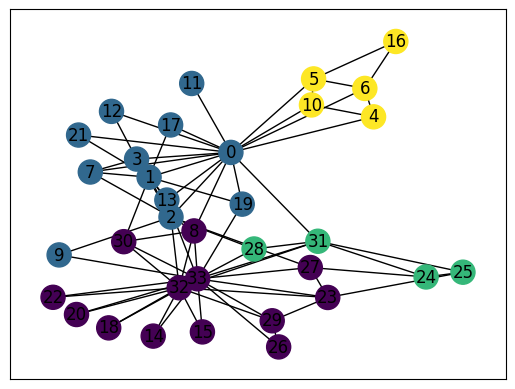

In [34]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw_networkx(G,node_color=data.y,pos=nx.spring_layout(G, seed=42))

## Verify properties of the graph Laplacian - TODO
The goal of the following questions is to empirically verify a few properties of the graph Laplacian matrix. In the **optional** exercise below, you are asked to mathematically establish those properties.

11. Compute the graph Laplacian matrix $\mathbf{L}$ for Zachary's karate club network. You are encouraged to use some suitable function from the subpackage [`torch_geometric.utils`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html).
12. Check that $\mathbf{L}$ has a 0 eigenvalue and verify that the vector of all ones $[1,1,\dots,1]^\top$ is the corresponding eigenvector. The subpackage [`torch.linalg`](https://pytorch.org/docs/stable/linalg.html) may be useful to that end.
13. Corroborate that $\mathbf{L}$ is a symmetric positive semidefinite matrix.
14. Form a matrix $\tilde{\mathbf{B}}$ as described in Part 2 of the optional exercise below and verify that $\mathbf{L}=\tilde{\mathbf{B}}\tilde{\mathbf{B}}^\top$. You are encouraged to use the function [`networkx.incidence_matrix`](https://networkx.org/documentation/stable/reference/generated/networkx.linalg.graphmatrix.incidence_matrix.html).

In [35]:
import torch
from torch_geometric.utils import get_laplacian, to_dense_adj
from torch_geometric.utils import to_networkx
import scipy.sparse

# INIT Karate graph (use PyG data)
data_karate = dataset[0]
edge_index = data_karate.edge_index
G_karate = to_networkx(data_karate, to_undirected=True)

In [36]:
# 11. Compute and print the graph Laplacian matrix L for Karate club (L = D - A)
from torch_geometric.utils import get_laplacian

edge_index_laplacian, edge_weight_laplacian = get_laplacian(
    edge_index, normalization=None, num_nodes=data_karate.num_nodes
)
L_coo = torch.sparse_coo_tensor(
    edge_index_laplacian,
    edge_weight_laplacian,
    (data_karate.num_nodes, data_karate.num_nodes)
)
L = L_coo.to_dense()
print("Graph Laplacian L = D - A:\n", L)

with open("report.md", "a") as f:
    f.write("11. Compute and print the graph Laplacian matrix L for Karate club (L = D - A):\n")
    f.write(f"{L}\n")

Graph Laplacian L = D - A:
 tensor([[16., -1., -1.,  ..., -1.,  0.,  0.],
        [-1.,  9., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., 10.,  ...,  0., -1.,  0.],
        ...,
        [-1.,  0.,  0.,  ...,  6., -1., -1.],
        [ 0.,  0., -1.,  ..., -1., 12., -1.],
        [ 0.,  0.,  0.,  ..., -1., -1., 17.]])


In [37]:
# 12. Zero eigenvalue and ones vector
eigenvalues, eigenvectors = torch.linalg.eigh(L)
print("12. Eigenvalues (first few):", eigenvalues[:5])
ones = torch.ones(data_karate.num_nodes)
L_times_ones = L @ ones
print("   L @ ones ≈ 0:", torch.allclose(L_times_ones, torch.zeros_like(ones)))
# Eigenvector corresponding to smallest eigenvalue (should be 0)
v0 = eigenvectors[:, 0]
print("   First eigenvector proportional to ones:", torch.allclose(v0 / v0[0], ones) or torch.allclose(-v0 / v0[0], ones))

with open("report.md", "a") as f:
    f.write("12. Zero eigenvalue and ones vector\n")
    f.write(f"   L @ ones ≈ 0: {torch.allclose(L_times_ones, torch.zeros_like(ones))}\n")
    f.write(f"   First eigenvector proportional to ones: {torch.allclose(v0 / v0[0], ones) or torch.allclose(-v0 / v0[0], ones)}\n")

12. Eigenvalues (first few): tensor([1.5138e-06, 4.6853e-01, 9.0925e-01, 1.1250e+00, 1.2594e+00])
   L @ ones ≈ 0: True
   First eigenvector proportional to ones: True


In [38]:
# 13. Symmetric and positive semidefinite
print("13. is L symmetric:", torch.allclose(L, L.T))
print("    Min eigenvalue ≥ 0:", (eigenvalues >= -1e-6).all().item())

with open("report.md", "a") as f:
    f.write("13. Symmetric and positive semidefinite\n")
    f.write(f"   is L symmetric: {torch.allclose(L, L.T)}\n")
    f.write(f"   Min eigenvalue ≥ 0: {(eigenvalues >= -1e-6).all().item()}\n")

13. is L symmetric: True
    Min eigenvalue ≥ 0: True


In [39]:
# 14. Signed incidence matrix B_tilde: L = B_tilde @ B_tilde.T
# NetworkX incidence_matrix with oriented=True gives signed incidence (tail=+1, head=-1)
B_nx = nx.incidence_matrix(G_karate, oriented=True)
B_tilde = torch.tensor(B_nx.toarray(), dtype=torch.float32)
L_from_B = B_tilde @ B_tilde.T
print("14. L = B_tilde @ B_tilde.T:", torch.allclose(L, L_from_B))

with open("report.md", "a") as f:
    f.write("14. Signed incidence matrix B_tilde: L = B_tilde @ B_tilde.T\n")
    f.write(f"   L = B_tilde @ B_tilde.T: {torch.allclose(L, L_from_B)}\n")

14. L = B_tilde @ B_tilde.T: True


# Optional exercise for extra credit: prove some properties of the graph Laplacian

Consider an undirected and unweighted network graph $G(V,E)$, with order $N_v:=|V|$, size $N_e:=|E|$, and adjacency matrix $\mathbf{A}$. Let $\mathbf{D}=\text{diag}(d_1,\ldots,d_{N_v})$ be the degree matrix and $\mathbf{L}:=\mathbf{D}-\mathbf{A}$ the Laplacian of $G$.

1. Verify that $\mathbf{1}:=[1,\ldots,1]^\top$ is an eigenvector of $\mathbf{L}$ with associated eigenvalue $0$.
2. Despite $G$ being an undirected graph, consider assigning an arbitrary "virtual" orientation to each edge in $E$, i.e., for each edge pick
one of its incident vertices as the "head" and the other as the "tail". Given these assignments, consider the *signed* incidence matrix $\tilde{\mathbf{B}}\in\{-1,0,1\}^{N_v\times N_e}$ with $i,j$-th entry given by
$$\tilde{\mathbf{B}}_{ij} = \left\lbrace
\begin{array}{r l}
1,& \text{if vertex } i \text{ is incident to edge } j \text{ as a tail}\\
-1,& \text{if vertex } i \text{ is incident to } j \text{ as a head}\\
0,& \text{otherwise}
\end{array}
\right. .
$$
Prove that the Laplacian matrix can be factorized as $\mathbf{L}=\tilde{\mathbf{B}}\tilde{\mathbf{B}}^\top$.

3. Consider an arbitrary vector $\mathbf{x}=[x_1,\ldots,x_{N_v}]^\top\in \mathbb{R}^{N_v}$. Using the result in Part 2 or otherwise, show that the quadratic form
$$\mathbf{x}^\top \mathbf{L}\mathbf{x} = \sum_{(i,j) \in E} (x_i-x_j)^2.$$
Conclude that $\mathbf{L}$ is a symmetric positive semi-definite matrix.


4. Show that if $G$ is disconnected then $\mathbf{L}$ is block diagonal, with each block corresponding to the Laplacian of a particular connected component in $G$. Argue that in this case the second smallest eigenvalue of $\mathbf{L}$ necessarily vanishes, by showing that one can construct at least two linearly independent eigenvectors of $\mathbf{L}$ with associated eigenvalue $0$.

# Acknowledgements

An intial version of this Laboratory (in Spanish) was conceived and developed by colleagues from [Facultad de Ingenieria](https://www.fing.edu.uy) in Montevideo, Uruguay and myself, for the course **[Aprendizaje Automático para Datos en Grafos](https://eva.fing.edu.uy/course/view.php?id=1626&section=0)**.

The first part in the section '**Introduction to PyTorch Geometric**' is based on [this notebook](https://colab.research.google.com/drive/16tqEHKOLUgYvXKx1V3blfYGpQb1_09MG?usp=sharing#scrollTo=bbny-iTO7NQN) from Stanford's course **[CS224W: Machine Learning with Graphs](http://web.stanford.edu/class/cs224w)**.